In [15]:
#Built an end-to-end pipeline that extracts official ISU results (SP + FS), cleans scoring fields, and produces a combined athlete-level dataset.
#Visualized how TES and PCS jointly relate to medal outcomes; top skaters cluster differently along technical vs component-driven profiles.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

SP_URL = "https://www.isuresults.com/results/season2223/wc2023/data0203.htm"
FS_URL = "https://www.isuresults.com/results/season2223/wc2023/data0205.htm"

In [8]:
def load_segment(url, season, event, discipline, segment):
    tables = pd.read_html(url, header=0)
    df = tables[0].copy()

    # 1) Hard normalize column names (removes weird spaces/unicode)
    df.columns = (
        pd.Index(df.columns)
        .map(lambda x: str(x).replace("\xa0", " ").strip())
    )

    # 2) Find the "competitor" column robustly
    cols_lower = {c.lower().strip(): c for c in df.columns}
    # common possibilities on ISU pages
    competitor_key = None
    for key in ["competitor", "skater", "name"]:
        if key in cols_lower:
            competitor_key = cols_lower[key]
            break
    if competitor_key is None:
        # fallback: any column containing "compet"
        for c in df.columns:
            if "compet" in c.lower():
                competitor_key = c
                break

    if competitor_key is None:
        raise ValueError(f"Could not find competitor column. Columns: {df.columns.tolist()}")

    # 3) Rename known columns (using the discovered competitor column)
    rename_map = {
        "Pl.": "rank_segment",
        competitor_key: "skater",
        "Nation": "nation",
        "TSS": "tss",
        "TES": "TES",
        "PCS": "PCS",
        "CO": "co",
        "PR": "pr",
        "SK": "sk",
        "Deduction": "deduction",
        "Qual.": "qual",
        "StN.": "start_no",
    }

    df = df.rename(columns=rename_map)

    # 4) Keep only relevant columns that actually exist
    want = ["rank_segment","skater","nation","tss","TES","PCS","co","pr","sk","deduction","qual","start_no"]
    df = df[[c for c in want if c in df.columns]].copy()

    # 5) Clean types
    df["skater"] = df["skater"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
    for c in ["rank_segment","tss","TES","PCS","co","pr","sk","deduction"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 6) Add metadata
    df["season"] = season
    df["event"] = event
    df["discipline"] = discipline
    df["segment"] = segment

    return df

In [9]:
season = "2022–2023"
event = "World Championships"
discipline = "Women"

sp = load_segment(SP_URL, season, event, discipline, "SP")
fs = load_segment(FS_URL, season, event, discipline, "FS")

sp.head(), fs.head()

(   rank_segment           skater nation    tss    TES    PCS    co    pr  \
 0             1   Kaori SAKAMOTO    JPN  79.24  42.81  36.43  9.04  9.21   
 1             2        Haein LEE    KOR  73.62  39.51  34.11  8.50  8.57   
 2             3       Mai MIHARA    JPN  73.46  39.08  34.38  8.57  8.57   
 3             4   Isabeau LEVITO    USA  73.03  39.10  33.93  8.54  8.61   
 4             5  Loena HENDRICKX    BEL  71.94  37.88  35.06  8.93  8.75   
 
      sk  deduction qual start_no     season                event discipline  \
 0  9.14        0.0    Q      #34  2022–2023  World Championships      Women   
 1  8.57        0.0    Q      #32  2022–2023  World Championships      Women   
 2  8.71        0.0    Q      #31  2022–2023  World Championships      Women   
 3  8.36        0.0    Q      #28  2022–2023  World Championships      Women   
 4  8.68        1.0    Q      #35  2022–2023  World Championships      Women   
 
   segment  
 0      SP  
 1      SP  
 2      SP  
 3

In [10]:
os.makedirs("../data/raw", exist_ok=True)

sp.to_csv("../data/raw/wc2023_women_sp.csv", index=False)
fs.to_csv("../data/raw/wc2023_women_fs.csv", index=False)

In [11]:
combined = sp.merge(
    fs,
    on=["skater", "nation", "season", "event", "discipline"],
    suffixes=("_sp", "_fs")
)

combined["TES_total"] = combined["TES_sp"] + combined["TES_fs"]
combined["PCS_total"] = combined["PCS_sp"] + combined["PCS_fs"]
combined["TSS_total"] = combined["tss_sp"] + combined["tss_fs"]

combined = combined.sort_values("TSS_total", ascending=False).reset_index(drop=True)
combined["rank_overall"] = np.arange(1, len(combined) + 1)
combined["is_medalist"] = combined["rank_overall"].isin([1,2,3]).astype(int)

combined.head(10)

,rank_segment_sp,skater,nation,tss_sp,TES_sp,PCS_sp,co_sp,pr_sp,sk_sp,deduction_sp,...,pr_fs,sk_fs,deduction_fs,start_no_fs,segment_fs,TES_total,PCS_total,TSS_total,rank_overall,is_medalist
0,1,Kaori SAKAMOTO,JPN,79.24,42.81,36.43,9.04,9.21,9.14,0.0,...,9.07,9.36,0.0,#24,FS,114.27,110.34,224.61,1,1
1,2,Haein LEE,KOR,73.62,39.51,34.11,8.50,8.57,8.57,0.0,...,8.96,8.93,0.0,#23,FS,115.04,105.90,220.94,2,1
2,5,Loena HENDRICKX,BEL,71.94,37.88,35.06,8.93,8.75,8.68,1.0,...,8.79,8.71,1.0,#20,FS,107.08,105.34,210.42,3,1
3,4,Isabeau LEVITO,USA,73.03,39.10,33.93,8.54,8.61,8.36,0.0,...,8.57,8.50,1.0,#21,FS,105.88,102.77,207.65,4,0
4,3,Mai MIHARA,JPN,73.46,39.08,34.38,8.57,8.57,8.71,0.0,...,8.43,8.61,0.0,#22,FS,102.83,102.87,205.70,5,0
5,12,Chaeyeon KIM,KOR,64.06,34.61,29.45,7.39,7.25,7.50,0.0,...,7.79,7.86,0.0,#13,FS,111.39,92.12,203.51,6,0
6,7,Nicole SCHOTT,GER,67.29,36.76,30.53,7.68,7.82,7.46,0.0,...,8.39,8.00,1.0,#18,FS,102.63,96.13,197.76,7,0
7,13,Kimmy REPOND,SUI,62.75,34.49,28.26,7.18,7.00,7.07,0.0,...,7.89,7.61,0.0,#12,FS,103.75,90.34,194.09,8,0
8,6,Niina PETROKINA,EST,68.00,36.70,31.30,7.79,7.89,7.86,0.0,...,7.96,7.89,0.0,#19,FS,98.22,95.27,193.49,9,0
9,15,Rinka WATANABE,JPN,60.90,30.17,31.73,8.07,7.79,8.00,1.0,...,7.96,8.11,1.0,#10,FS,98.93,95.88,192.81,10,0


In [12]:
os.makedirs("../data/processed", exist_ok=True)
combined.to_csv("../data/processed/wc2023_women_combined.csv", index=False)
print("Saved processed:", "../data/processed/wc2023_women_combined.csv")

Saved processed: ../data/processed/wc2023_women_combined.csv


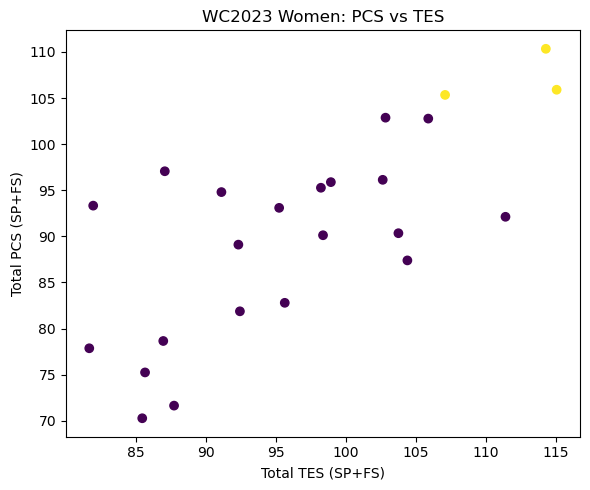

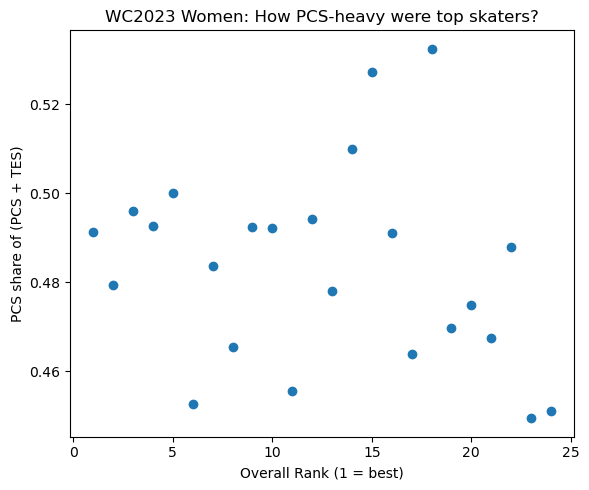

Saved figures to ../reports/figures/


In [13]:
import matplotlib.pyplot as plt

os.makedirs("../reports/figures", exist_ok=True)

# Plot 1: PCS vs TES (colored by medalist)
plt.figure(figsize=(6,5))
plt.scatter(combined["TES_total"], combined["PCS_total"], c=combined["is_medalist"])
plt.xlabel("Total TES (SP+FS)")
plt.ylabel("Total PCS (SP+FS)")
plt.title("WC2023 Women: PCS vs TES")
plt.tight_layout()
plt.savefig("../reports/figures/wc2023_women_pcs_vs_tes.png", dpi=200)
plt.show()

# Plot 2: Contribution share (PCS / (PCS+TES)) vs overall rank
combined["pcs_share"] = combined["PCS_total"] / (combined["PCS_total"] + combined["TES_total"])
plt.figure(figsize=(6,5))
plt.scatter(combined["rank_overall"], combined["pcs_share"])
plt.xlabel("Overall Rank (1 = best)")
plt.ylabel("PCS share of (PCS + TES)")
plt.title("WC2023 Women: How PCS-heavy were top skaters?")
plt.tight_layout()
plt.savefig("../reports/figures/wc2023_women_pcs_share_vs_rank.png", dpi=200)
plt.show()

print("Saved figures to ../reports/figures/")


In [18]:
# TES_total and PCS_total are both strongly correlated with final rank, with TES slightly stronger in determining medal eligibility.
combined[["TES_total","PCS_total","TSS_total","rank_overall"]].corr()

,TES_total,PCS_total,TSS_total,rank_overall
TES_total,1.000000,0.723195,0.922675,-0.922720
PCS_total,0.723195,1.000000,0.932365,-0.910945
TSS_total,0.922675,0.932365,1.000000,-0.987351
rank_overall,-0.922720,-0.910945,-0.987351,1.000000


In [19]:
"""
Key Takeaways:
Figure 1: 
    Medalists cluster in the upper-right quadrant (high TES and high PCS). 
    TES is necessary but not sufficient: some skaters with high TES sit lower in PCS and do not medal.
    Among the top technical skaters, PCS differentiates podium order.
Figure 2: 
    Top finishers do not have dramatically higher PCS shares.
    PCS share is relatively flat across ranks (~0.47–0.53).
    The best skaters win by raising both components, not by being disproportionately PCS-heavy.

Conclusions: 
    TES determines who can contend; PCS determines how high they place
    Medalists are balanced, not PCS-dominant
    SP keeps skaters close; FS decides outcomes
"""

'\nKey Takeaways:\nFigure 1: \n    Medalists cluster in the upper-right quadrant (high TES and high PCS). \n    TES is necessary but not sufficient: some skaters with high TES sit lower in PCS and do not medal.\n    Among the top technical skaters, PCS differentiates podium order.\nFigure 2: \n    Top finishers do not have dramatically higher PCS shares.\n    PCS share is relatively flat across ranks (~0.47–0.53).\n    The best skaters win by raising both components, not by being disproportionately PCS-heavy.\n\nConclusions: \n    TES determines who can contend; PCS determines how high they place\n    Medalists are balanced, not PCS-dominant\n    SP keeps skaters close; FS decides outcomes\n'

In [20]:
"""
Analysis of the 2023 World Figure Skating Championships (among women) shows that technical 
execution (TES) determines which skaters are capable of contending for medals, while program 
components (PCS) differentiate placement among top technical skaters. Medalists are not 
disproportionately PCS-heavy; instead, they succeed by achieving high absolute scores in both 
components. These results suggest that modern judging rewards balanced performance rather 
than specialization, with the Free Skate playing a dominant role in final ranking separation.
"""

'\nAnalysis of the 2023 World Figure Skating Championships (among women) shows that technical \nexecution (TES) determines which skaters are capable of contending for medals, while program \ncomponents (PCS) differentiate placement among top technical skaters. Medalists are not \ndisproportionately PCS-heavy; instead, they succeed by achieving high absolute scores in both \ncomponents. These results suggest that modern judging rewards balanced performance rather \nthan specialization, with the Free Skate playing a dominant role in final ranking separation.\n'